In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from functools import partial
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import resample


In [3]:
df = pd.read_csv('dataset.csv', index_col=0)

In [17]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 20)

In [6]:
print('%20s %18s %18s %6s' %('Имя', 'Тип данных', 'Кол-во пропусков', '%'))
for col in df.columns:
    print('%20s %15s %13d %15.1f' %(col, df[col].dtypes, df[col].isna().sum(), df[col].isna().sum() / df.shape[0] * 100))

                 Имя         Тип данных   Кол-во пропусков      %
              gender          object             0             0.0
       SeniorCitizen           int64             0             0.0
             Partner          object             0             0.0
          Dependents          object             0             0.0
              tenure           int64             0             0.0
        PhoneService          object             0             0.0
       MultipleLines          object             0             0.0
     InternetService          object             0             0.0
      OnlineSecurity          object             0             0.0
        OnlineBackup          object             0             0.0
    DeviceProtection          object             0             0.0
         TechSupport          object             0             0.0
         StreamingTV          object             0             0.0
     StreamingMovies          object             0             

CustomerId : Идентификатор клиента  
gender : Пол  
SeniorCitizen : Является ли клиент пожилым гражданином (1, 0)  
Partner : Есть ли у клиента партнер (да, нет)? Женат или нет. Живут вместе, являются соседями  
Dependents : Имеет ли клиент иждивенцев (да, нет) (ребенок, мать, отец, бабушка)  
Tenure : число месяцев, в течение которых клиент работает с компанией  
PhoneService : Имеет ли клиент телефонную связь (да, нет)  
MultipleLines : Имеет ли клиент более одной линии (да, нет, нет телефонной службы)  
InternetService : Поставщик интернет-услуг клиента (DSL, Fiber optic, No)  
OnlineSecurity : Есть ли у клиента безопасность в сети (да, нет, нет интернет-сервиса)  
OnlineBackup : Есть ли у клиента онлайн-резервное копирование (да, нет, нет интернет-сервиса)  
DeviceProtection : Есть ли у клиента защита устройств (да, нет, нет интернет-сервиса)  
TechSupport : Получает ли клиент техническую поддержку (да, нет, нет интернет-сервиса)  
StreamingTV : Есть ли у клиента трансляция TV (да, нет, нет интернет-сервиса)  
StreamingMovies : Есть ли у клиента потоковые фильмы (да, нет, нет интернет-сервиса) (Ииспользует ли клиент интернет-сервис для трансляции фильмов от провайдера)  
Contract : Срок действия договора с клиентом (месяц к месяцу, один год, два года)  
PaperlessBilling: Есть ли у клиента бумажный счет (да, нет)  
PaymentMethod : Способ оплаты клиента (электронный чек, почтовый чек, банковский перевод (автоматический), кредитная карта (автоматическая)])  
MonthlyCharges : Сумма, взимаемая с клиента ежемесячно  
TotalCharges : Общая сумма, взимаемая с клиента  
Churn : Использует клиент или нет (да или нет) - Клиенты, которые ушли в прошлом месяце или квартале


Заметим, что столбец TotalCharges при чтении воспринимается как object, переведем в numeric

In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

In [8]:
df = df.dropna()

**1)**  Анализ пропущенных значений

В датасете присутствуют 11 пропущенных в столбец TotalCharges.
Это подтверждается проверкой с использованием функций обнаружения NaN или пустых ячеек во всех столбцах.  
Ввиду малого объема удалим записи с пропущенными значениями.

**Перейдем к разведочному анализу данных (EDA).**

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [10]:
df.describe(include=['object']).T

,count,unique,top,freq
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094
TechSupport,7032,3,No,3472


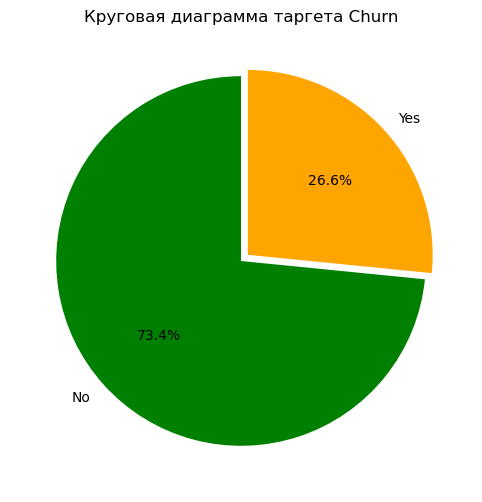

In [11]:
plt.figure(figsize=(10, 6))
plt.pie(
    df.Churn.value_counts(),
    labels=df.Churn.value_counts().index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['green', 'orange'],
    explode=(0, 0.05)
)
plt.title('Круговая диаграмма таргета Churn')
plt.show()

**Обратим внимание на умеренный дисбаланс классов. Учтем при дальнейшем обучении модели.**

Ниже построим тепловую карту (матрицу корреляций) численных признаков:

<Axes: >

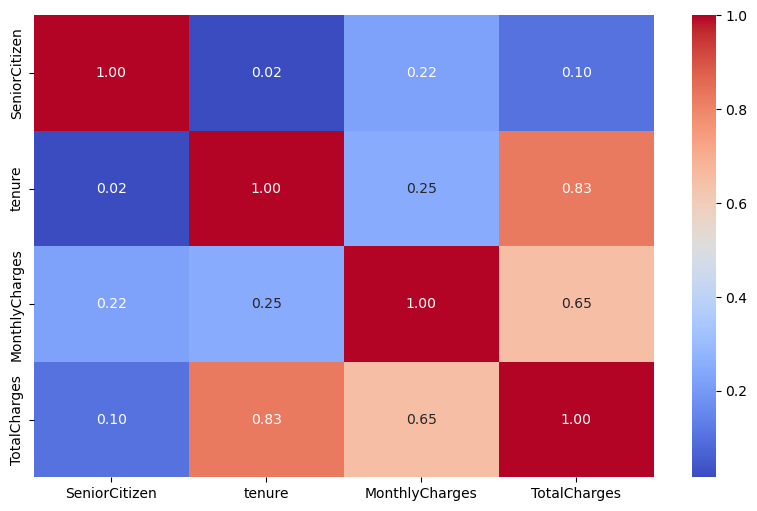

In [12]:
df_num = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', fmt=".2f")

Присутствует сильная прямая корреляция между TotalCharges (сумма платежа) и tenure (количество месяцев, сколько клиент сотрудничает с компанией)  
Означает, что чем больше клиент сотрудничает с компанией, тем больше его суммы заказов  

Менее слабая, но имеющая статистическую значимость корреция между TotalCharges (сумма платежа) и MonthlyCharges (сумма, взимаемая с клиента ежемесячно). Чем больше клиент платит каждый месяц, тем выше его общая сумма платежей (вполне разумная корреляция)

Text(0.5, 1.0, 'Тепловая карта категориальных признаков')

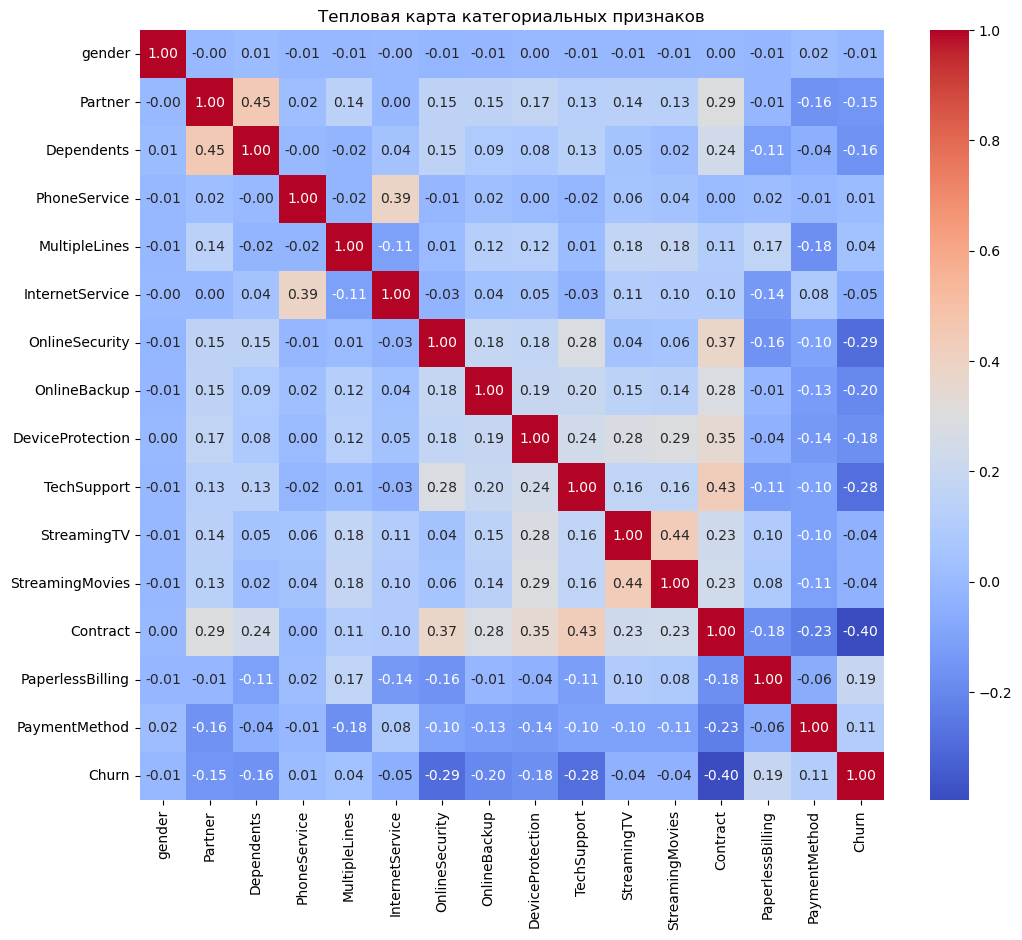

In [13]:
categorical_cols = df.select_dtypes(include='object').columns

df_encoded = df[categorical_cols].copy()
le = LabelEncoder()
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

corr = df_encoded.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта категориальных признаков')

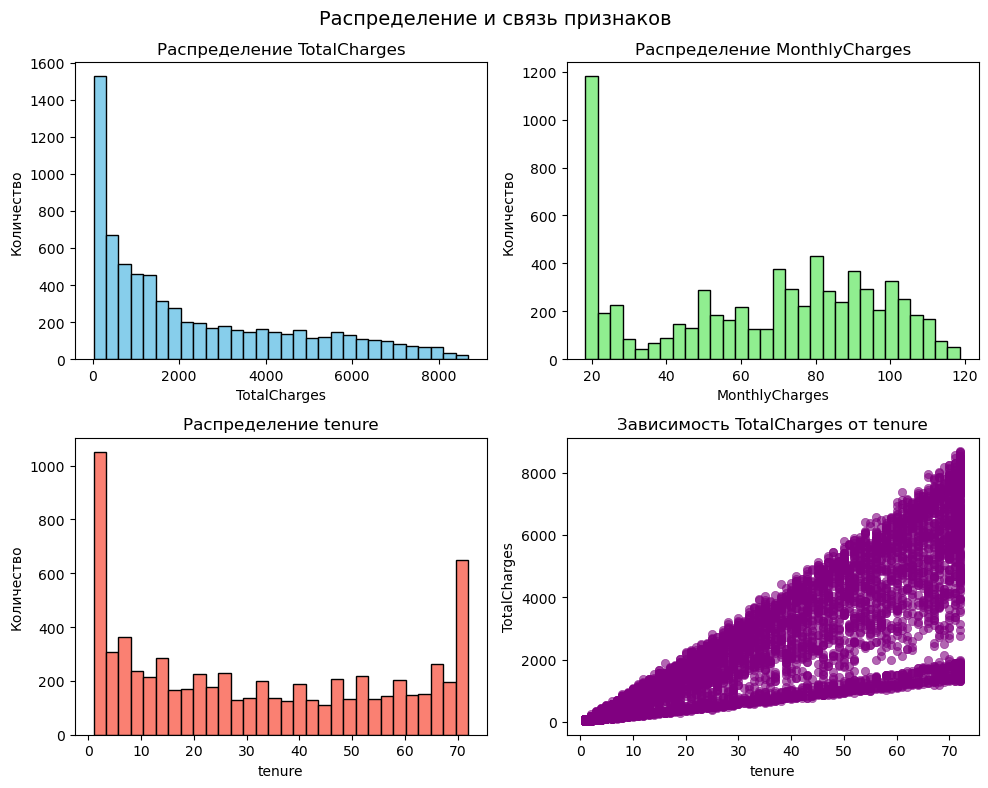

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].hist(df['TotalCharges'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение TotalCharges')
axes[0, 0].set_xlabel('TotalCharges')
axes[0, 0].set_ylabel('Количество')

axes[0, 1].hist(df['MonthlyCharges'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Распределение MonthlyCharges')
axes[0, 1].set_xlabel('MonthlyCharges')
axes[0, 1].set_ylabel('Количество')

axes[1, 0].hist(df['tenure'], bins=30, color='salmon', edgecolor='black')
axes[1, 0].set_title('Распределение tenure')
axes[1, 0].set_xlabel('tenure')
axes[1, 0].set_ylabel('Количество')

sns.scatterplot(
    data=df,
    x='tenure',
    y='TotalCharges',
    ax=axes[1, 1],
    color='purple',
    alpha=0.6,
    edgecolor=None
)
axes[1, 1].set_title('Зависимость TotalCharges от tenure')
axes[1, 1].set_xlabel('tenure')
axes[1, 1].set_ylabel('TotalCharges')

plt.suptitle('Распределение и связь признаков', fontsize=14)
plt.tight_layout()
plt.show()


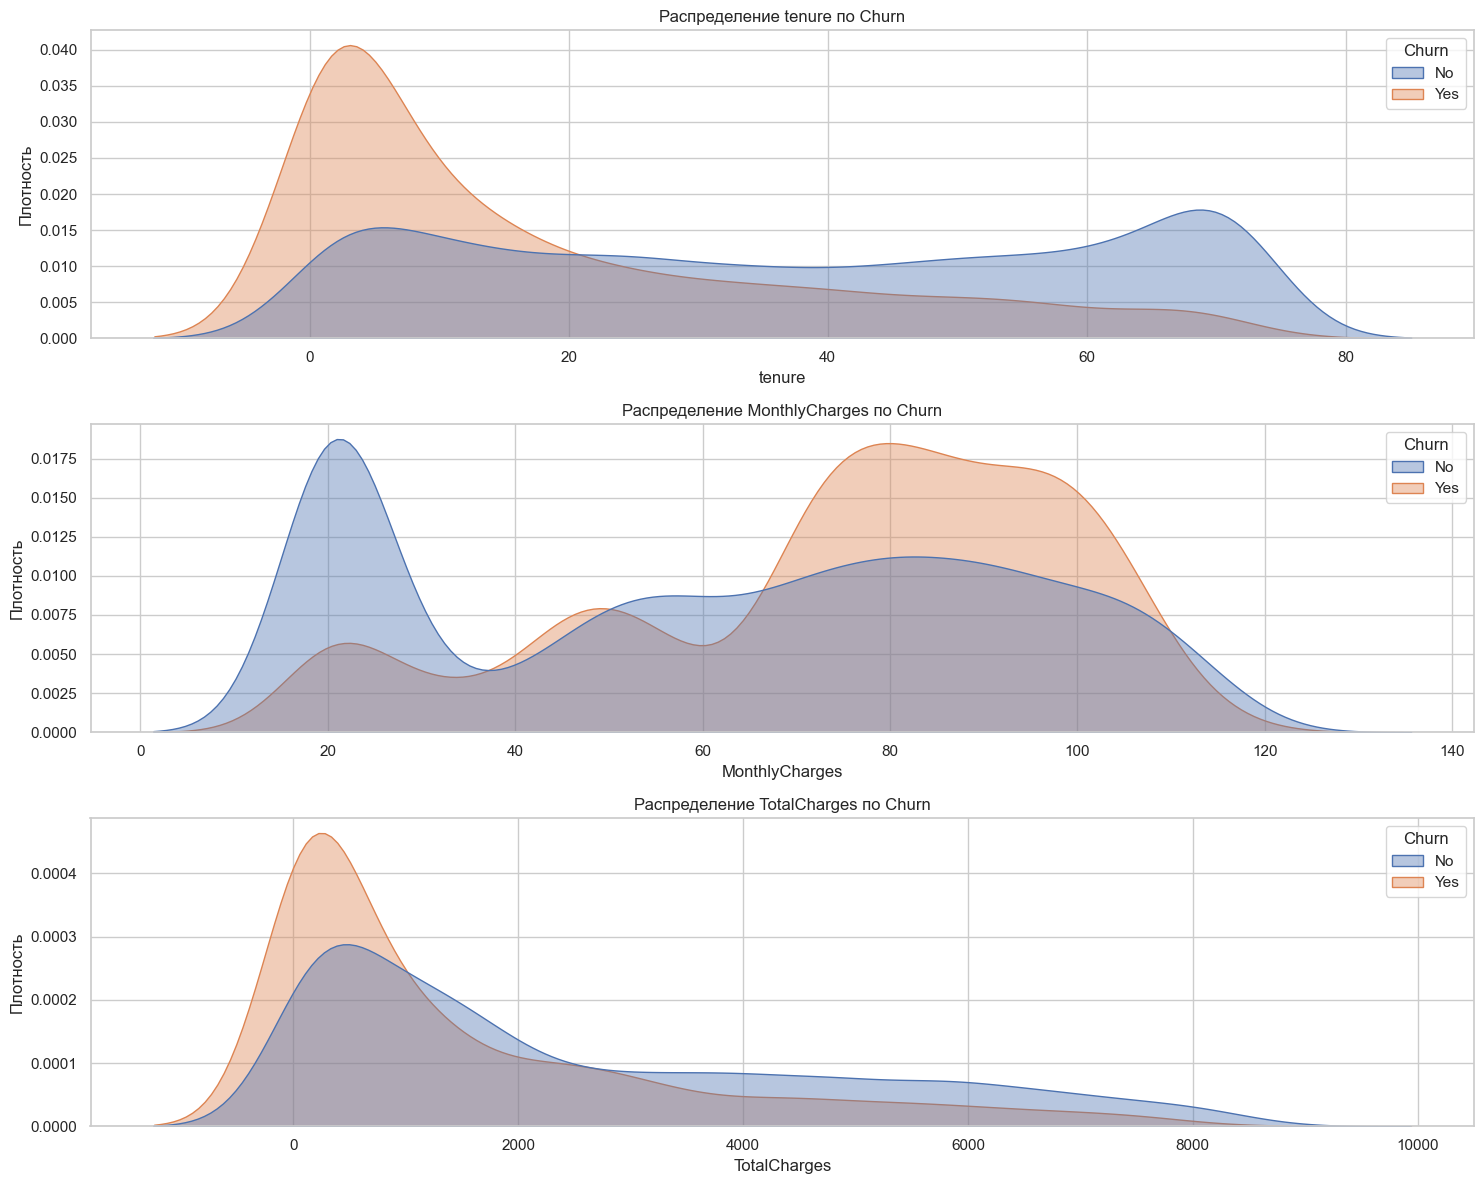

In [15]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.set(style='whitegrid')
plt.figure(figsize=(15, 4 * len(num_cols)))

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(len(num_cols), 1, i)
    sns.kdeplot(
        data=df,
        x=col,
        hue='Churn',
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax
    )

    ax.set_title(f'Распределение {col} по Churn')
    ax.set_xlabel(col)
    ax.set_ylabel('Плотность')

    if ax.legend_:
        ax.legend_.set_title('Churn')

plt.tight_layout()

Время пользования услугами влияет на целевую переменную. Наиболее склонны к уходу пользователи, пользующиеся услугами менее 20 месяцев.  
Ежемесячный платеж влияет на отток пользователей. Начиная с 65 у.е. стоимости услуги возрастает количество ушедших пользователей.

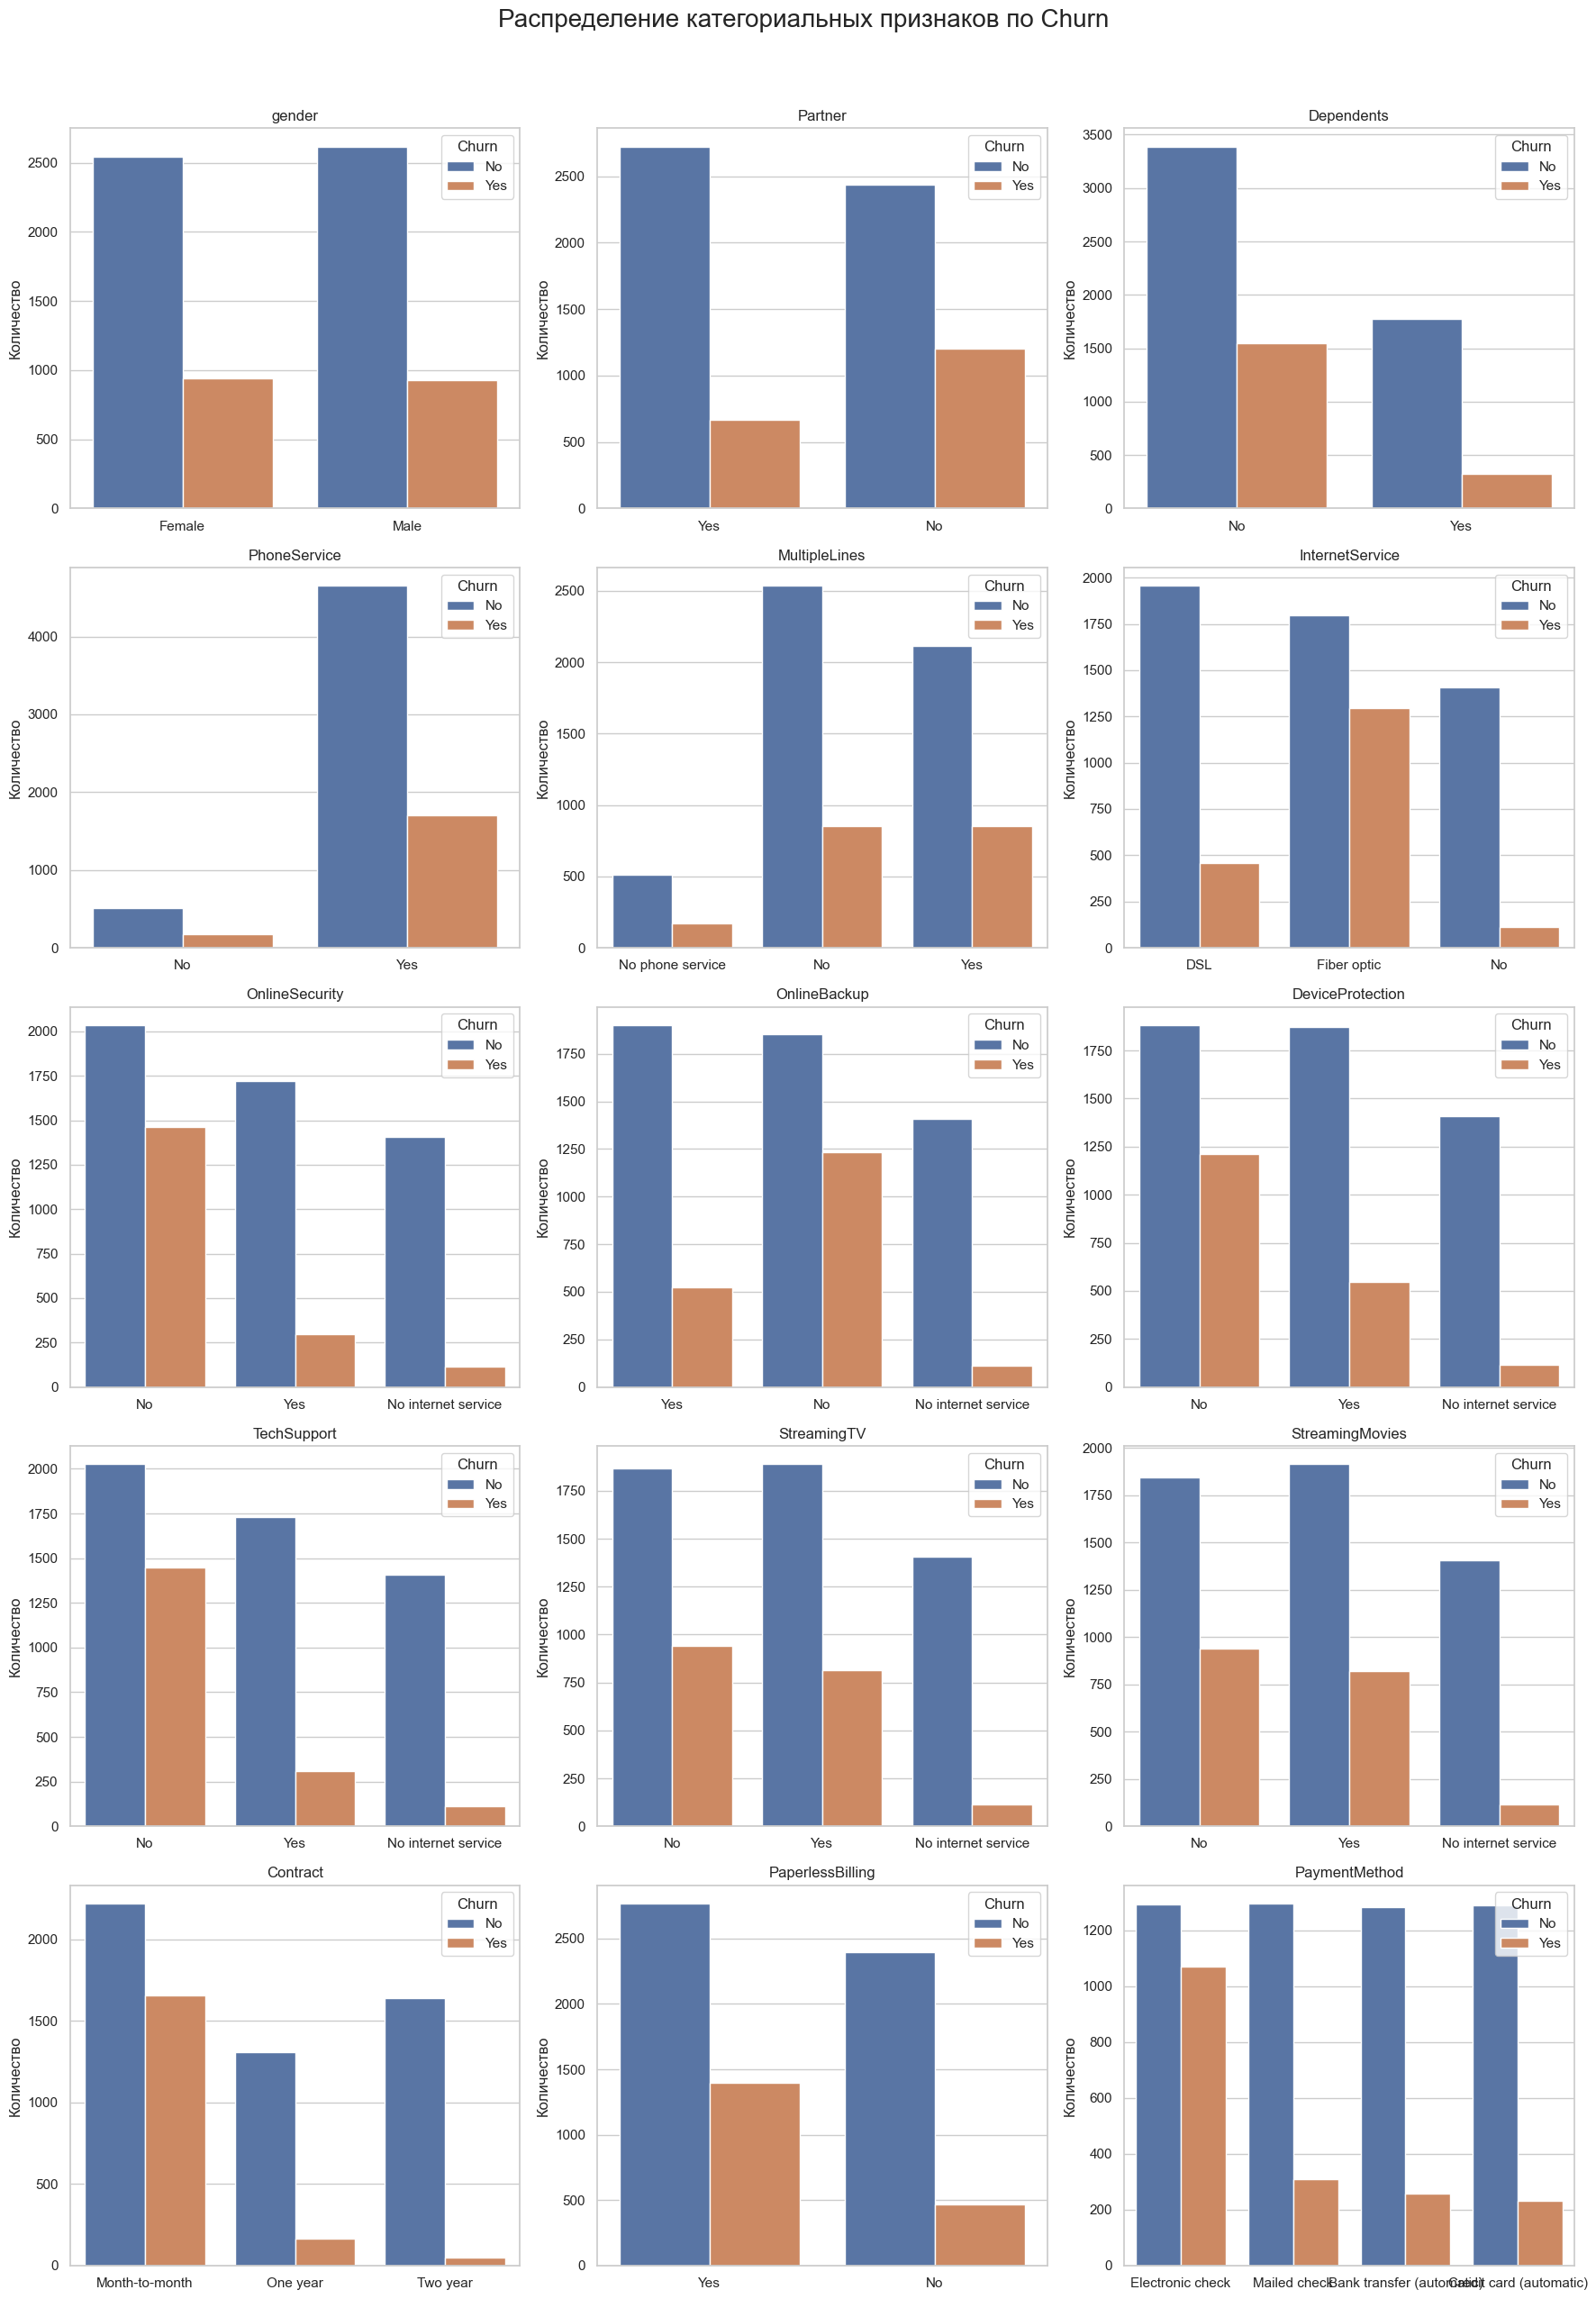

In [16]:
cat_cols = df.select_dtypes(include=['object']).columns.drop('Churn')
sns.set(style='whitegrid')
n_cols = 3 
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 25))
axes = axes.flatten()


for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df, x=col, hue='Churn', ax=ax)
    ax.set_title(f'{col}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Количество')

    if df[col].nunique() > 4:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    if ax.legend_:
        ax.legend_.set_title('Churn')

for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Распределение категориальных признаков по Churn', fontsize=20, y=1.02)
plt.tight_layout()

По диаграммам заметим, что более подвержены уходу клиенты с оплатой "month-to-month", типом подключения "Fiber-Optic", оплата "электронный чек"  
Распределения, связанные с пользованием услугами резервного копирования/потоковых фильмов/защиты устройств являются схожими, чаще всего уходят клиенты, не использующие эти услуги.


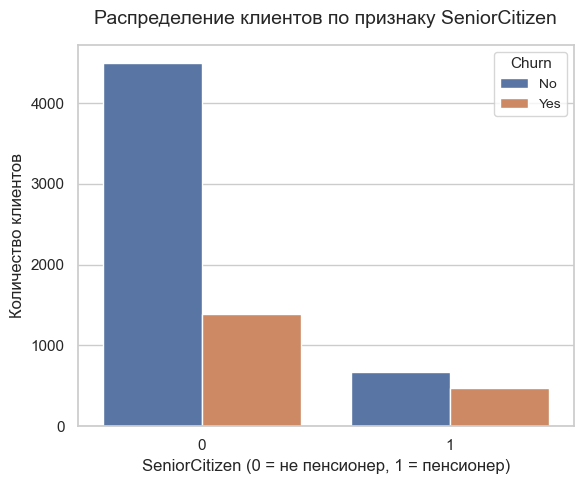

In [18]:
sns.set(style='whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='SeniorCitizen', hue='Churn')
ax.set_title('Распределение клиентов по признаку SeniorCitizen', fontsize=14, pad=15)
ax.set_xlabel('SeniorCitizen (0 = не пенсионер, 1 = пенсионер)', fontsize=12)
ax.set_ylabel('Количество клиентов', fontsize=12)
ax.legend(title='Churn', title_fontsize=11, fontsize=10, loc='upper right')
plt.tight_layout()

К уходу более склонны лица пенсионного возраста (видим практически равное соотношение)

**Построим портрет пользователя, наиболее склонного к уходу:**

In [19]:
df_churn = df[df.Churn == 'Yes'].copy()
def get_churn_info(
    data: pd.DataFrame,
    cat_col: list,
    num_col: list,
) -> pd.DataFrame:

    result = pd.DataFrame()
    
    for col in cat_col:
        result.loc[col, 'value'] = data[col].value_counts().index[0]

    for num in num_col:
        result.loc[num, 'value'] = round(data[num].mean())
    
    return result

get_churn_info(
    data = df_churn,
    cat_col = ['Contract', 'PaymentMethod', 'InternetService', 'MultipleLines'],
    num_col = ['MonthlyCharges', 'TotalCharges', 'tenure']
)

,value
Contract,Month-to-month
PaymentMethod,Electronic check
InternetService,Fiber optic
MultipleLines,Yes
MonthlyCharges,74
TotalCharges,1532
tenure,18


__________________________________________________________________________________________
**Перейдем к обучению модели. Воспользуемся градиентным бустингом из библиотеки Catboost 
(были рассмотрены другие модели, catboost показывает наилучший результат)**

In [20]:
data = df.drop(['Churn', 'Partner', 'gender', 'DeviceProtection', 'StreamingTV', 'SeniorCitizen', 'Dependents', 'PhoneService'], axis=1)
target = df['Churn']
feat = [f for f in data.columns] 
categorical = [f for f in feat if df[f].dtype == 'object' or f == 'SeniorCitizen']
target_bin = target.map({'No': 0, 'Yes': 1})

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

auc_test_list = []
auc_train_list = []
precision_list = []
recall_list = []
accuracy_list = []
f1_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(data), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_val = data.iloc[train_idx].copy(), data.iloc[val_idx].copy()
    y_train, y_val = target_bin.iloc[train_idx], target_bin.iloc[val_idx]

    train_df = X_train.copy()
    train_df['target'] = y_train

    df_majority = train_df[train_df.target == 0]
    df_minority = train_df[train_df.target == 1]

    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    X_train = df_balanced.drop('target', axis=1)
    y_train = df_balanced['target']

    print(f"Размер после undersampling: {X_train.shape[0]} (1: {sum(y_train==1)}, 0: {sum(y_train==0)})")
    numeric_features = [featur for featur in feat if featur not in categorical]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
        ]
    )


    logreg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])

    rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=300, max_depth=6, random_state=42, class_weight='balanced', n_jobs=-1))
    ])

    cat = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.01,
        depth=4,
        loss_function='Logloss',
        eval_metric='AUC',
        random_state=42,
        verbose=300
    )

    logreg.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    cat.fit(X_train, y_train, cat_features=categorical)

    y_train_pred_prob = (
        0.25 * logreg.predict_proba(X_train)[:, 1] +
        0.25 * rf.predict_proba(X_train)[:, 1] +
        0.5 * cat.predict_proba(X_train)[:, 1]
    )
    y_val_pred_prob = (
        0.25 * logreg.predict_proba(X_val)[:, 1] +
        0.25 * rf.predict_proba(X_val)[:, 1] +
        0.5 * cat.predict_proba(X_val)[:, 1]
    )

    threshold = 0.55
    y_val_pred = (y_val_pred_prob >= threshold).astype(int)
    y_train_pred = (y_train_pred_prob >= threshold).astype(int)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_val = roc_auc_score(y_val, y_val_pred_prob)
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_val)

    precision_list.append(precision_score(y_val, y_val_pred))
    recall_list.append(recall_score(y_val, y_val_pred))
    accuracy_list.append(accuracy_score(y_val, y_val_pred))
    f1_list.append(f1_score(y_val, y_val_pred))

# --- Итог ---
print("\n===== Итоговые средние метрики ансамбля =====")
print(f"Средний Train AUC: {np.mean(auc_train_list):.4f}")
print(f"Средний Test AUC: {np.mean(auc_test_list):.4f}")
print(f"Среднее расхождение (с train): "
      f"{np.mean(np.abs(np.array(auc_test_list) - np.array(auc_train_list)) / np.array(auc_train_list) * 100):.2f}%")
print(f"Средний Precision: {np.mean(precision_list):.4f}")
print(f"Средний Recall: {np.mean(recall_list):.4f}")
print(f"Средняя Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Средний F1-score: {np.mean(f1_list):.4f}")


===== Fold 1 =====
Размер после undersampling: 2990 (1: 1495, 0: 1495)
0:	total: 248ms	remaining: 4m 7s
300:	total: 4.29s	remaining: 9.97s
600:	total: 8.54s	remaining: 5.67s
900:	total: 13s	remaining: 1.43s
999:	total: 14.5s	remaining: 0us

===== Fold 2 =====
Размер после undersampling: 3018 (1: 1509, 0: 1509)
0:	total: 13.4ms	remaining: 13.4s
300:	total: 5.22s	remaining: 12.1s
600:	total: 10.5s	remaining: 7s
900:	total: 15.4s	remaining: 1.7s
999:	total: 17s	remaining: 0us

===== Fold 3 =====
Размер после undersampling: 2950 (1: 1475, 0: 1475)
0:	total: 12.1ms	remaining: 12.1s
300:	total: 4.46s	remaining: 10.4s
600:	total: 9.47s	remaining: 6.29s
900:	total: 14.1s	remaining: 1.55s
999:	total: 15.7s	remaining: 0us

===== Fold 4 =====
Размер после undersampling: 3036 (1: 1518, 0: 1518)
0:	total: 12.6ms	remaining: 12.5s
300:	total: 4.53s	remaining: 10.5s
600:	total: 9.27s	remaining: 6.15s
900:	total: 14.2s	remaining: 1.55s
999:	total: 15.7s	remaining: 0us

===== Fold 5 =====
Размер после 

<Figure size 600x600 with 0 Axes>

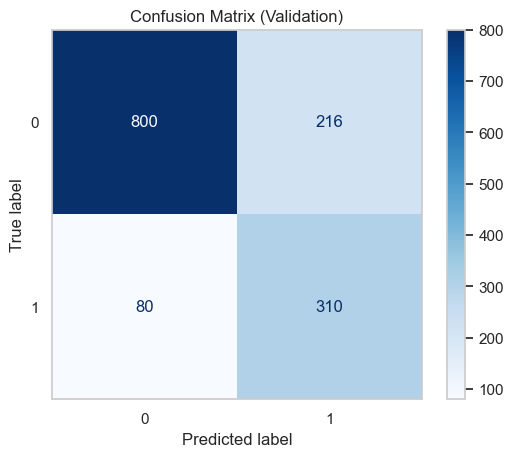

In [27]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (Validation)')
plt.grid(False)

Text(0.5, 1.0, 'Важность признаков ансамбля')

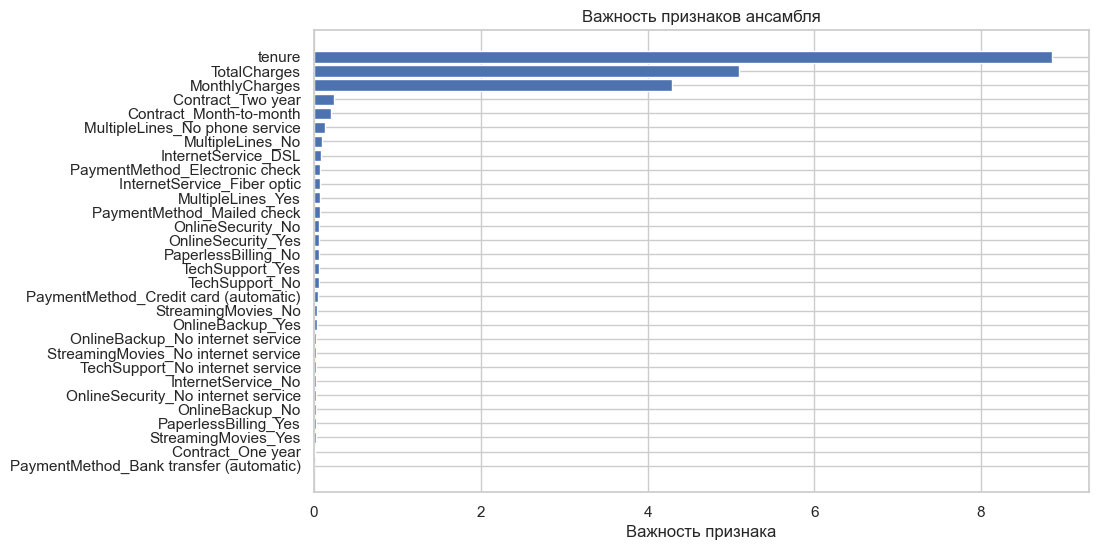

In [26]:
rf_importances = rf.named_steps['model'].feature_importances_
rf_features = rf.named_steps['preprocessor'].transformers_[0][2] + list(rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical))
rf_df = pd.DataFrame({'feature': rf_features, 'importance': rf_importances})
rf_df.sort_values(by='importance', ascending=False, inplace=True)

logreg_importances = logreg.named_steps['model'].coef_[0]
logreg_features = rf_features  
logreg_df = pd.DataFrame({'feature': logreg_features, 'importance': np.abs(logreg_importances)})
logreg_df.sort_values(by='importance', ascending=False, inplace=True)

cat_importances = cat.get_feature_importance(prettified=True)
cat_df = pd.DataFrame({'feature': cat_importances['Feature Id'], 'importance': cat_importances['Importances']})

ensemble_df = pd.DataFrame({'feature': rf_features})
ensemble_df = ensemble_df.merge(rf_df[['feature','importance']], on='feature', how='left').rename(columns={'importance':'rf'})
ensemble_df = ensemble_df.merge(logreg_df[['feature','importance']], on='feature', how='left').rename(columns={'importance':'logreg'})
ensemble_df = ensemble_df.merge(cat_df[['feature','importance']], on='feature', how='left').rename(columns={'importance':'cat'})
ensemble_df.fillna(0, inplace=True)

ensemble_df['importance'] = 0.25*ensemble_df['logreg'] + 0.25*ensemble_df['rf'] + 0.5*ensemble_df['cat']
ensemble_df.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
plt.barh(ensemble_df['feature'], ensemble_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Важность признака")
plt.title("Важность признаков ансамбля")